In [6]:
from inference.spatial_compartmental.viz import SI_stoch_viz
from abm.spatial_compartmental.si import get_abm
from abm.spatial_compartmental.utils import _NEIGHBOURHOOD_DICT,Neighbourhood
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import time

## Variability of SI ABM

In [2]:
abm = get_abm(Neighbourhood.DIAGONAL,vmap=True)


<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_100272/978316904.py:23: SyntaxWarning: invalid escape sequence '\m'
  axarr[idx, 0].set_ylabel(f'$p_{{\mathrm{{infect}}}}$ = {p_infect}', rotation=90, labelpad=20, va='center',fontsize=12)


10 0.019999992
40 0.024999987
160 0.024999987
10 0.09999995
40 0.09999995
160 0.09999995
10 0.3999998
40 0.3999998
160 0.3999998
10 0.019999992
40 0.024999987
160 0.024999987
10 0.09999995
40 0.09999995
160 0.09999995
10 0.3999998
40 0.3999998
160 0.3999998
10 0.019999992
40 0.024999987
160 0.024999987
10 0.09999995
40 0.09999995
160 0.09999995
10 0.3999998
40 0.3999998
160 0.3999998


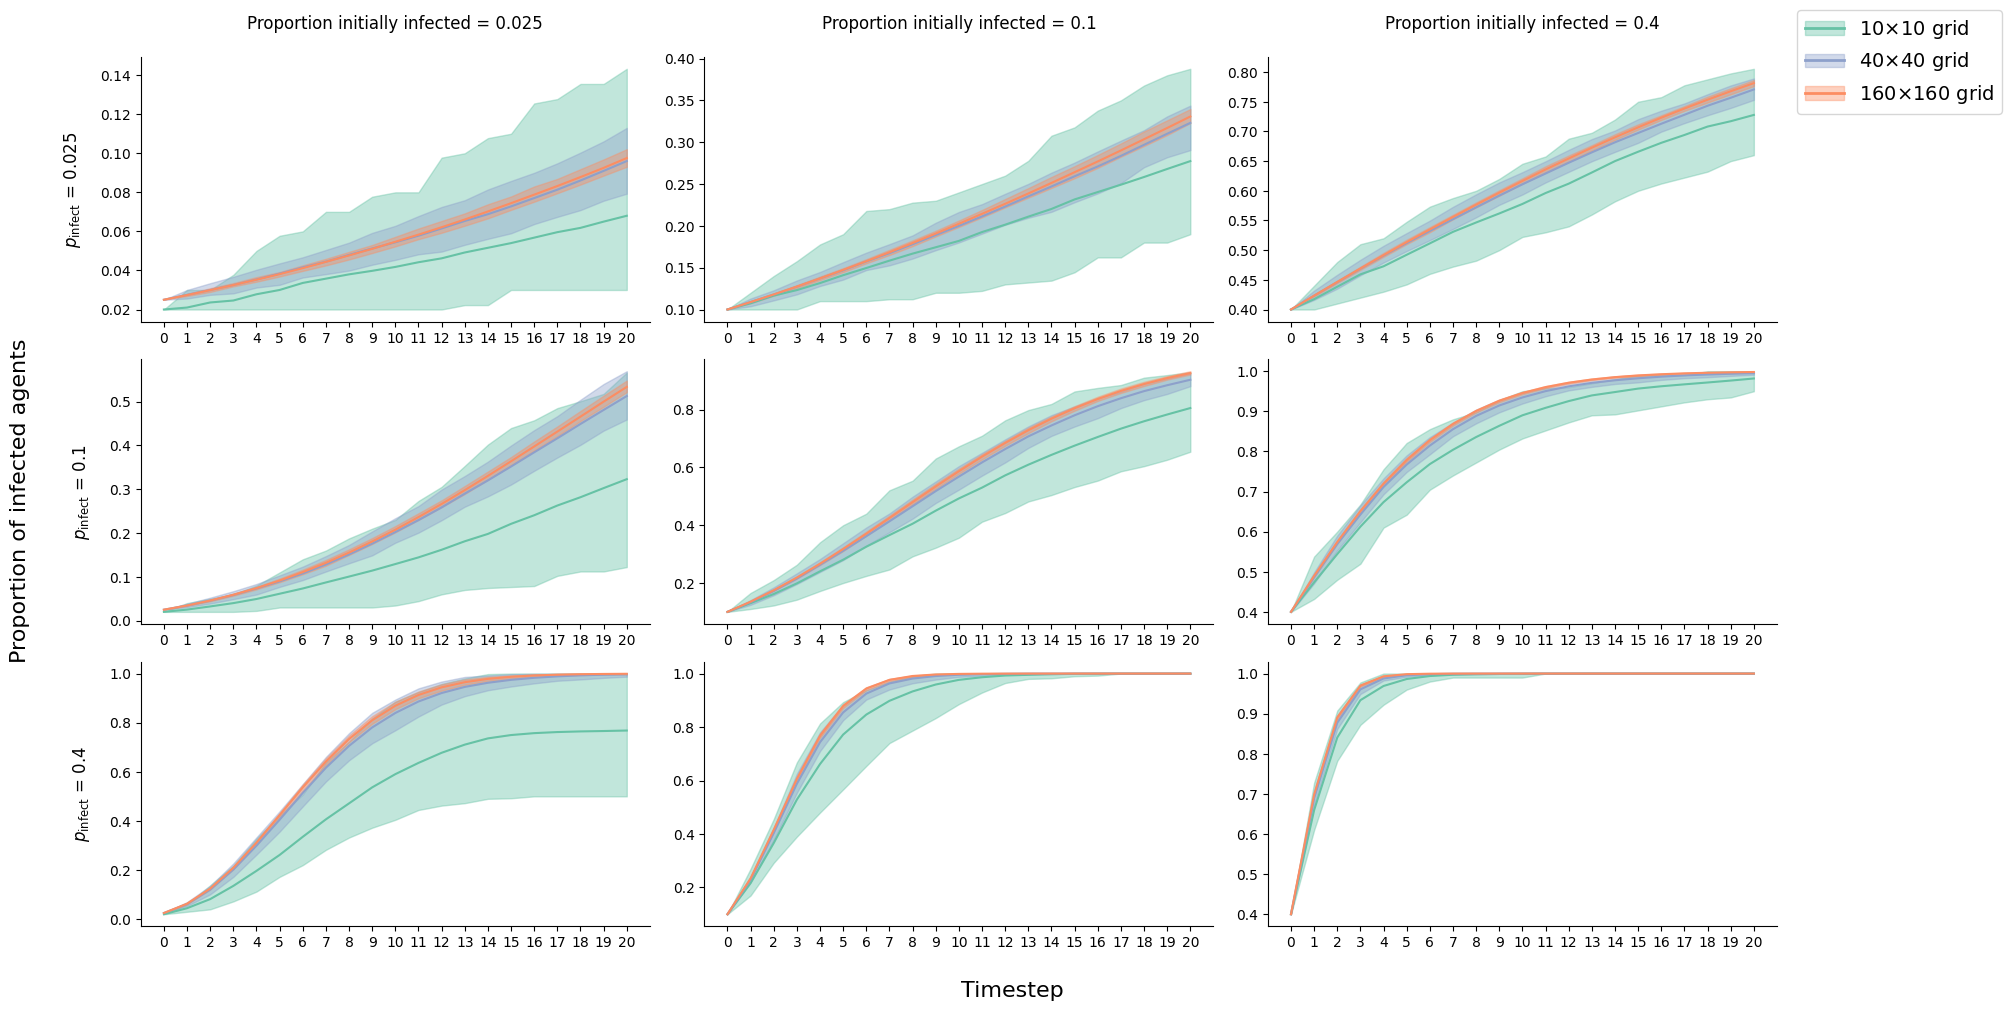

In [3]:
fig, axarr = plt.subplots(3,3, figsize=(20,10))

for i,p_infect in enumerate([0.025, 0.1, 0.4]):
    for j,prop_initial_infected in enumerate([0.025,0.1,0.4]):
        SI_stoch_viz(axarr[i,j], abm , p_infect=p_infect, prop_initial_infected=prop_initial_infected, num_steps=20, grid_sizes=[10,40,160], 
                     #Colourblind friendly from https://colorbrewer2.org/#type=qualitative&scheme=Set2&n=3
                    colours=['#66c2a5', '#8da0cb', '#fc8d62'], #['#33a02c', '#1f78b4', '#e31a1c']
                    abm_keys=jax.random.split(jax.random.PRNGKey(0),50), ci_alpha=0.4,mean_or_median='mean',
                    beautify_spines=True, xlim=(None,None))

fig.supylabel('Proportion of infected agents',fontsize=16,x=-0.001)
fig.supxlabel('Timestep',fontsize=16,y=-0.001)
legend_handles=[]
legend_labels=[]
for colour, grid_size in zip(['#66c2a5', '#8da0cb', '#fc8d62'],[10,40,160]):
    legend_handles.append((Line2D([0],[0],color=colour,
                           linestyle='-', linewidth=2),mpatches.Patch(color=colour,alpha=0.4)))
    legend_labels.append(f"{grid_size}"+r'$\times$'+f"{grid_size} grid")
fig.legend(handles=legend_handles, labels=legend_labels,
           loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=fig.transFigure,fontsize=14)

for idx,p_infect in enumerate([0.025, 0.1, 0.4]):
    axarr[idx, 0].set_ylabel(f'$p_{{\mathrm{{infect}}}}$ = {p_infect}', rotation=90, labelpad=20, va='center',fontsize=12)

for jdx, initial_infected in enumerate([0.025, 0.1, 0.4]):
    axarr[0,jdx].set_xlabel(f"Proportion initially infected = {initial_infected}",labelpad=20,fontsize=12)
    axarr[0, jdx].xaxis.set_label_position('top') 
    
plt.tight_layout(rect=[0, 0, 0.89, 1],h_pad=1,w_pad=1)
plt.savefig('mini_SI_diag_stoch.pdf', bbox_inches='tight')
plt.show()

## Convolution-based ABM vs Original

In [5]:
def prob_epi_SI(grid_size, num_steps, p_infect, initial_infected):
    """
    A JAX-compatible ABM spatial S-I model.
    """
    states = jnp.zeros((grid_size, grid_size))
    initial_infections = jax.random.bernoulli(jax.random.PRNGKey(0), initial_infected, (grid_size, grid_size))
    states = states + initial_infections  # initial infections

    neighbors = jnp.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])

    def update_cell(states, pos, key):
        i, j = pos
        key, subkey = jax.random.split(key)

        def infect_neighbor(neighbor_offset, acc_infected):
            ni, nj = i + neighbor_offset[0], j + neighbor_offset[1]
            in_bounds = (ni >= 0) & (nj >= 0) & (ni < grid_size) & (nj < grid_size)
            neighbor_infect = in_bounds & (states[ni, nj] == 1) & (jax.random.uniform(subkey) < p_infect)
            return acc_infected | neighbor_infect

        infected = jax.lax.fori_loop(0, neighbors.shape[0], lambda idx, acc: infect_neighbor(neighbors[idx], acc), False)
        infected = infected.astype(jnp.int32)
        return jax.lax.cond(states[i, j] == 1, lambda _: jnp.int32(1), lambda _: infected, None)

    def update_grid(states, step_key):
        keys = jax.random.split(step_key, grid_size * grid_size).reshape(grid_size, grid_size, 2)
        positions = jnp.array([(i, j) for i in range(grid_size) for j in range(grid_size)])

        def update_single_cell(pos, grid):
            key = keys[pos[0], pos[1]]
            new_value = update_cell(states, pos, key)
            return grid.at[pos[0], pos[1]].set(new_value)

        return jax.lax.fori_loop(0, positions.shape[0], lambda idx, grid: update_single_cell(positions[idx], grid), states)

    def step_fn(states, step_key):
        next_states = update_grid(states, step_key)
        S_t = jnp.sum(1 - next_states)
        I_t = jnp.sum(next_states)
        return next_states, (S_t, I_t)

    keys = jax.random.split(jax.random.PRNGKey(0), num_steps)
    _, (S_list, I_list) = jax.lax.scan(step_fn, states, keys)

    return states, S_list, I_list


In [ ]:
jabm = jax.jit(abm, static_argnums=[1,2,4])
#NOTE: The prob epi version doesn't actually accept different keys(likely a bug), 
# so we vmap over p_infect just for the purposes of being able to sample a vmapped batch
v_prob_epi = jax.vmap(prob_epi_SI, in_axes=[None,None,0,None])
j_prob_epi = jax.jit(v_prob_epi, static_argnums=[0,1,3]) 

abm_means=[]
abm_25_perc=[]
abm_975_perc=[]


prob_epi_means=[]
prob_epi_25_perc=[]
prob_epi_975_perc=[]



for grid_size in [10,40,160]:
    #Trace and Jit before timing
    jabm(jax.random.split(jax.random.key(0),50), grid_size, 20, 0.2, 10)[0].block_until_ready()

    j_prob_epi(grid_size, 20, 0.2*jnp.ones((50,)), 0.1)[0].block_until_ready()

    abm_times = []
    prob_epi_times = []
    for i in range(50):
        start = time.monotonic()
        jabm(jax.random.split(jax.random.key(0),50), grid_size, 20, 0.2, 10)[0].block_until_ready()
        abm_times.append(time.monotonic()-start)
        
        start = time.monotonic()
        j_prob_epi(grid_size, 20, 0.2*jnp.ones((50,)), 0.1)[0].block_until_ready()
        prob_epi_times.append(time.monotonic()-start)

    abm_times=jnp.array(abm_times)
    prob_epi_times=jnp.array(prob_epi_times)
    
    abm_means.append(jnp.mean(abm_times))
    abm_25_perc.append(jnp.percentile(abm_times, 2.5))
    abm_975_perc.append(jnp.percentile(abm_times,97.5))

    prob_epi_means.append(jnp.mean(prob_epi_times))
    prob_epi_25_perc.append(jnp.percentile(prob_epi_times, 2.5))
    prob_epi_975_perc.append(jnp.percentile(prob_epi_times,97.5))



In [ ]:
print([x/y for x,y in zip(prob_epi_means,abm_means)])

[Array(38.226055, dtype=float32), Array(370.64603, dtype=float32), Array(620.32666, dtype=float32)]
[Array(0.04248136, dtype=float32), Array(0.73282635, dtype=float32), Array(10.758891, dtype=float32)]


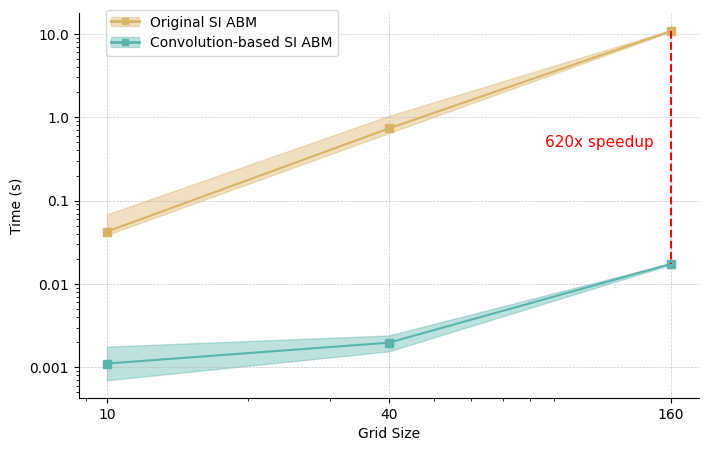

In [142]:
fig, ax = plt.subplots(figsize=(8,5))
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot([10,40,160], prob_epi_means,color='#d8b365',marker='s')
ax.fill_between([10,40,160], prob_epi_25_perc, prob_epi_975_perc,color='#d8b365',alpha=0.4)

ax.plot([10,40,160],abm_means,color='#5ab4ac',marker='s')
ax.fill_between([10,40,160], abm_25_perc, abm_975_perc,color='#5ab4ac',alpha=0.4)
ax.spines[["right", "top"]].set_visible(False)
#
ax.set_xticks([10,40,160])
ax.set_xticklabels([10,40,160])
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_yticks([1e-3, 1e-2, 1e-1, 1e0, 1e1])
ax.set_yticklabels([0.001,0.01,0.1,1.0,10.0])


ax.plot([160,160], [prob_epi_means[-1], abm_means[-1]],
        color='red',
        linestyle='--',) # or 'dotted'
        #linewidth=1.5)
#ax.set_xticklabels(grid_sizes)
mid_y_line = 0.5#(float(prob_epi_means[-1]) + float(abm_means[-1])) / 2
ax.annotate('620x speedup',
            xy=(160, mid_y_line),      # Point on the line for the arrow tip (remains the same)
            xytext=(-12, 0),                 # Text offset: -15 points to the LEFT, 0 points vertically
                                             # The negative value moves it left. Adjust -15 as needed.
            textcoords='offset points',      # Interpret xytext as offset in points from xy (remains the same)
            # arrowprops=dict(arrowstyle="->", # Defines arrow type
            #                 color='red',
            #                 shrinkA=5,
            #                 shrinkB=5),
            color='red',
            ha='right',                      # Horizontal alignment of the text: text will be to the right of xytext point
                                             # so the text body is to the left of the arrow
            va='center',                     # Vertical alignment of the text (remains the same)
            fontsize=11,
            # Optional: add a bounding box for better readability
            #bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", lw=0.5, alpha=0.8)
           )

legend_handles=[]
legend_labels=['Original SI ABM', 'Convolution-based SI ABM']
for colour in['#d8b365','#5ab4ac']:
    legend_handles.append((Line2D([0],[0],color=colour,
                           linestyle='-', marker='s',markersize=4,linewidth=2),mpatches.Patch(color=colour,alpha=0.4)))
fig.legend(handles=legend_handles, labels=legend_labels, loc='upper left',bbox_to_anchor=(0.15, 0.9))
          # loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=fig.transFigure,fontsize=10)

ax.set_xlabel('Grid Size',y=-0.001)
ax.set_ylabel('Time (s)')
#plt.tight_layout(rect=[0, 0, 0.89, 1],h_pad=1,w_pad=1)
fig.savefig('si_abm_speedup.pdf')
plt.show()